In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from src.data.retrieve_data import get_msdFlow, get_usgs_data
from src.data.prepare_input_data import prepare_data_in
from src.models.performance_metrics import calc_nse_ln, calc_nse


# GET DATA

msd_flow     = get_msdFlow()
usgs_flow    = get_usgs_data()*0.646 # convert to MGD


# max_msd_flows           = {'MFWQTC(MGD)' : 5,
#                         'DRGWQTC(MGD)': 0,
#                         'CCWQTC(MGD)' : 2, 
#                         'FFWQTP(MGD)' : 0,
#                         'HCWQTP(MGD)' : 2
#                         }

# removed_data = {}
# for msd_name, max_flow in max_msd_flows.items():
#     removed_data[msd_name] = (msd_flow[msd_name] < max_flow).sum()
#     msd_flow.loc[msd_flow[msd_name] < max_flow, msd_name] = np.nan 

# |------------------------------------Match data -------------------------------------|
# Get station names
usgs_names  = usgs_flow.columns
msd_names   = msd_flow.columns


# match time series
full_Df = usgs_flow.join(msd_flow).dropna().resample('D').asfreq().interpolate('linear')

# ------------------------------------Matched time series-------------------------------|

usgs_flow_match = full_Df[usgs_names]
msd_match       = full_Df[msd_names]
                               

In [3]:
from settings import param_file
label_size      = 0.7* param_file.params["Fig_OOB_GOF"]["label_size"] 
ticklabel_size  = 0.6*param_file.params["Fig_OOB_GOF"]["ticklabel_size"] 
colors          = param_file.params["Fig_OOB_GOF"]["colors"] 
title_size      = 0.7*param_file.params["Fig_OOB_GOF"]["title_size"] 
hspace          = param_file.params["Fig_OOB_GOF"]["hspace"] 
wspace          = param_file.params["Fig_OOB_GOF"]["wspace"] 
legend_lbl_size = 0.7*param_file.params["Fig_OOB_GOF"]["legend_lbl_size"] 

title_mapper      = param_file.params["Fig_OOB_GOF"]["titles"]

# Functions

In [4]:
def oob_tracker(model, trainX, trainy, min_estimators = 50, max_estimators = 600, step = 25):
    error_rate = []
    for i in range(min_estimators, max_estimators + 1, step):
        model.set_params(n_estimators=i)
        model.fit(trainX, trainy)
        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = model.oob_score_
        error_rate.append((i, oob_error))
        
    return error_rate

In [5]:
max_samples  = 0.7
random_state = 10
test_frac = 1/3

min_estimators = 10
max_estimators = 200
step = max(1, round(0.1*(max_estimators - min_estimators)))



gauge_list           = {'MFWQTC(MGD)' : ['03293530', '03293000', '03293510', '03292555', '03292500'],
                        'DRGWQTC(MGD)': ['03292555', '03293510', '03293530', '03293000', '03292500'],
                        'CCWQTC(MGD)' : ['03292555', '03293000', '03293530', '03293510', '03292500'], 
                        'FFWQTP(MGD)' : ['03293000', '03292555', '03293510', '03293530', '03292500'],
                        'HCWQTP(MGD)' : ['03292555', '03293530', '03293510', '03293000', '03292500']
                        }



oob_err_wwtps_list = []
for Qwwtp_lags in [0,1]:
   oob_err_wwtps = {}

   for msd_name, discharge_gauges in gauge_list.items():


   # discharge_gauges = gauge_list[msd_name]
      msd_series       = msd_match[msd_name]

      

      oob_err_gages = {}
      for ngages in range(1, len(discharge_gauges)+1):

         
         model = RandomForestRegressor(  max_samples  = max_samples, 
                                       random_state = random_state,
                                       # max_features = "sqrt",            
                                       warm_start=True,
                                       oob_score=True,
                                    )
         
         discharge       = usgs_flow_match[discharge_gauges[0:ngages]]
         data, var_names = prepare_data_in(discharge, msd_series, precip = None, Qusgs_lags = 0, Qwwtp_lags = Qwwtp_lags)

         
         n_test = round(test_frac*data.shape[0])

         trainX, testX = data[:-n_test, :-1], data[-n_test:, :-1]
         trainy, testy = data[:-n_test, -1], data[-n_test:, -1]

         error_rate = oob_tracker(model, trainX, trainy, min_estimators = min_estimators, max_estimators = max_estimators, step = step)

         oob_err_gages[ngages] = error_rate 

         

      oob_err_wwtps[msd_name] = oob_err_gages 
   oob_err_wwtps_list.append(oob_err_wwtps)

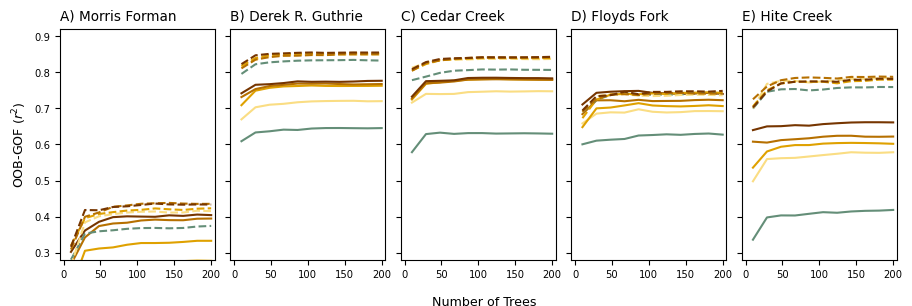

In [7]:


fig, axs = plt.subplots(1,5, figsize = (12*0.9,3), sharey = True, sharex = True)
lgnd_hnd_lbls = []
for lag, oob_err_wwtps in zip([0,1], oob_err_wwtps_list):

    axes_idx  = 0
    for ax, msd_name in zip(axs, oob_err_wwtps.keys()): 

        linestyle = "-" if lag==0 else "--"

        oob_err_gages = oob_err_wwtps[msd_name]
        for gages, error_rate in oob_err_gages.items():
            trees, oob_err = zip(*error_rate)
            h, = ax.plot(trees, oob_err, label = gages, color = colors[gages - 1], linestyle = linestyle)
            if (lag == 0) and (axes_idx == 0):
                lgnd_hnd_lbls.append((h, gages))

        ax.set_ylim(0.28,0.92)
        ax.set_xlim(-5, max_estimators + 5)
        ax.tick_params(labelsize = ticklabel_size)

        if lag == 0:
            ax.set_title(title_mapper[msd_name], fontsize = title_size, loc = "left")
        # else:
            # ax.set_xlabel("Num. Trees", fontsize =label_size)

        if axes_idx == 0:
            
            ax.set_ylabel(r"OOB-GOF ($r^{2}$)",fontsize =label_size)

        axes_idx += 1

hnd, lbl = ax.get_legend_handles_labels()

lgnd_hnd_lbls

h, l = zip(*lgnd_hnd_lbls[::-1])

custom_lines = [Line2D([0], [0], color = "grey", linestyle = "-"),
                Line2D([0], [0], color = "grey", linestyle = "--")]
ax.annotate("Number of Trees", xy = (0.4,0), xycoords = "figure fraction", fontsize = label_size, bbox={"facecolor": "white", "edgecolor":"white"})

plt.subplots_adjust(wspace = wspace, hspace = hspace)
    
plt.savefig('./Results/Poster_Figs/figOOB_GOF.png', bbox_inches='tight', dpi = 500)